<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Appendix 2: Model Stacking</h2>
<br>



<a href="#1.-Twitter-Airline-Sentiment Data">Twitter Airline Sentiment Data</a> <br>
<a href="#2.-Classification-Models">Classification Models</a> <br>
<a href="#3.-Voting-Classifiers">Voting Classifiers</a> <br>
<a href="#4.-Model-Stacking">Model Stacking</a> <br>
<a href="#5.-Model-Evaluation">Model Evaluation</a> <br>

This notebook relies on the following imports and settings.

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(crayon) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix, log_loss

from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  RandomForestClassifier
import lightgbm as lgb

### 1. Twitter Airline Sentiment Data
 
In this lesson we revisit the Twitter airline sentiment dataset. To save time, we directly load the processed dataset that we constructed in the earlier lesson. 

In [4]:
import h5py
f = h5py.File('data/tweets-matrices.h5', 'r')
f.keys()

<KeysViewHDF5 ['X_test', 'X_train', 'y_test', 'y_train']>

In [5]:
from scipy.sparse import csr_matrix

y_train = np.ravel(f.get('y_train'))
y_test = np.ravel(f.get('y_test'))

X_train = csr_matrix(f.get('X_train'))
X_test = csr_matrix(f.get('X_test'))

f.close()

In [6]:
features = pd.read_csv('data/tweets_features.csv').iloc[:,0].values.tolist()

###  2. Classification Models

**2.1 Naive Bayes**

In [7]:
nbc= BernoulliNB()
nbc.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

**2.2 Regularised Logistic Regression**

In [8]:
logit_l1= LogisticRegressionCV(Cs = 50, penalty='l1', solver='liblinear', scoring='neg_log_loss', cv=5)
logit_l1.fit(X_train, y_train)

LogisticRegressionCV(Cs=50, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l1',
           random_state=None, refit=True, scoring='neg_log_loss',
           solver='liblinear', tol=0.0001, verbose=0)

In [9]:
C = logit_l1.C_
logit_l1= LogisticRegression(C = C[0], penalty='l1', solver='liblinear')
logit_l1.fit(X_train, y_train)

LogisticRegression(C=1.2067926406393288, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [10]:
np.sum(np.abs(logit_l1.coef_) == 0.0)

170

In [11]:
logit_l2= LogisticRegressionCV(Cs = 50, penalty='l2', scoring='neg_log_loss', cv=5)
logit_l2.fit(X_train, y_train)

LogisticRegressionCV(Cs=50, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring='neg_log_loss',
           solver='lbfgs', tol=0.0001, verbose=0)

In [12]:
C = logit_l2.C_
logit_l2= LogisticRegression(C = C[0], penalty='l2')
logit_l2.fit(X_train, y_train)

LogisticRegression(C=1.2067926406393288, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

**3.2 Random Forest**

In [13]:
%%time

model = RandomForestClassifier(criterion = 'entropy',  n_estimators=100)

tuning_parameters = {
    'min_samples_leaf': [1, 5, 10, 20, 50],
    'max_features': np.arange(25, X_train.shape[1], 25),
}

rf_search = RandomizedSearchCV(model, tuning_parameters, cv = 5, n_iter= 64, scoring='neg_log_loss', n_jobs=4)
rf_search.fit(X_train, y_train)

rf = rf_search.best_estimator_

print('Best parameters found by randomised search:', rf_search.best_params_, '\n')

Best parameters found by randomised search: {'min_samples_leaf': 5, 'max_features': 75} 

Wall time: 2min 33s


In [14]:
rf.n_estimators = 1000
rf.random_state = 1
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=75, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

**3.3 XGBoost**

In [15]:
from xgboost import XGBClassifier
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV

In [16]:
%%time

model = XGBClassifier(reg_lambda=0)

space = {
    'learning_rate': Real(0.005, 0.15),
    'n_estimators' : Integer(100, 2000),
    'max_depth' : Integer(1, 4),
    'subsample' : Real(0.5, 1.0),
    'colsample_bynode' : Real(0.01, 1.0),
}

np.random.seed(87)
xgb_search =  BayesSearchCV(model, space, cv = 5,  n_iter=32, scoring = 'neg_log_loss', n_jobs=4)
xgb_search.fit(X_train, y_train)

xgb = xgb_search.best_estimator_

print('Best parameters found by Bayesian estimation:', xgb_search.best_params_, '\n')

Best parameters found by Bayesian estimation: {'colsample_bynode': 0.01, 'learning_rate': 0.10566347884368385, 'max_depth': 2, 'n_estimators': 2000, 'subsample': 0.8017562932483941} 

Wall time: 3min 31s


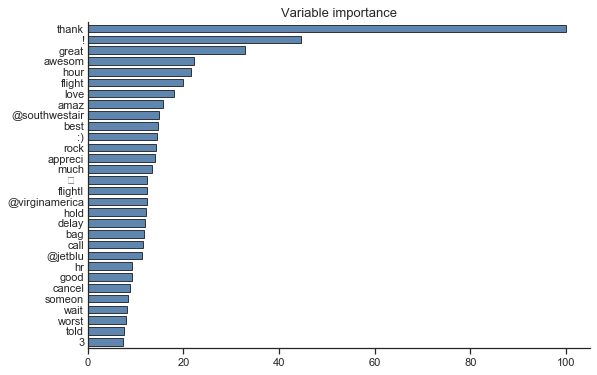

In [17]:
from statlearning import plot_feature_importance
plot_feature_importance(xgb, features, max_features=30)
plt.show()

**3.4 LightGBM**

I'm setting up the search space for LightGBM differently from XGBoost to encourage diversity between the two models. 

In [18]:
from lightgbm import LGBMClassifier

In [19]:
%%time

model = LGBMClassifier()

space = {
    'reg_alpha':  (1e-10, 1000, 'log-uniform'),
    'learning_rate': Real(0.005, 0.15),
    'n_estimators' : Integer(100, 2000),
    'num_leaves' : Integer(2, 2**10),
    'subsample' : Real(0.5, 1.0),
    'colsample_bytree' : Real(0.1, 1.0),
}

np.random.seed(87)
lgb_search =  BayesSearchCV(model, space, cv = 5,  n_iter=32, scoring = 'neg_log_loss', n_jobs=4)
lgb_search.fit(X_train, y_train)

lgb = lgb_search.best_estimator_

print('Best parameters found by Bayesian optimisation:', lgb_search.best_params_, '\n')

Best parameters found by Bayesian optimisation: {'colsample_bytree': 0.24033294057834173, 'learning_rate': 0.008747588861198552, 'n_estimators': 1639, 'num_leaves': 775, 'reg_alpha': 0.0004650112859185637, 'subsample': 0.6201332323738978} 

Wall time: 6min 35s


**3.5 Linear Support Vector Classifier**

In [20]:
%%time

from sklearn.svm import LinearSVC

Cs = np.logspace(-10, 10, 81, base=2)

model = LinearSVC(loss='hinge')

tuning_parameters ={
    'C': Cs,
}

svm_search = GridSearchCV(model, tuning_parameters, cv=5, return_train_score=False, n_jobs=4)
svm_search.fit(X_train, y_train)

svm = svm_search.best_estimator_

print('Best parameters found by grid search:', svm_search.best_params_, '\n')

Best parameters found by grid search: {'C': 0.125} 

Wall time: 5.27 s


## 3. Voting Classifier

In [21]:
from sklearn.ensemble import VotingClassifier

clfs = [('clf1', nbc), ('clf2',  logit_l1), ('clf3',  logit_l2),  ('clf4',  xgb), ('clf5',  svm) 
        ,('clf6', lgb)]

vhard = VotingClassifier(clfs)
vhard.fit(X_train, y_train)

VotingClassifier(estimators=[('clf1', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)), ('clf2', LogisticRegression(C=1.2067926406393288, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', ran...    silent=True, subsample=0.6201332323738978,
        subsample_for_bin=200000, subsample_freq=0))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [22]:
clfs = [('clf1', nbc), ('clf2', logit_l1), ('clf3',  logit_l2), ('clf4',  xgb),  ('clf5',  lgb)]
# We exclude SVM since it does not predict probabilities

vsoft = VotingClassifier(clfs, voting='soft')
vsoft.fit(X_train, y_train)

VotingClassifier(estimators=[('clf1', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)), ('clf2', LogisticRegression(C=1.2067926406393288, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', ran...    silent=True, subsample=0.6201332323738978,
        subsample_for_bin=200000, subsample_freq=0))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

## 4. Model Stacking


In [25]:
%%time
from mlxtend.classifier import StackingCVClassifier

stack = StackingCVClassifier([nbc, logit_l1, logit_l2, xgb, lgb], use_probas=True, 
                             meta_classifier = LogisticRegression(C=np.inf, solver='lbfgs'), cv=5)
stack.fit(X_train, y_train) 

Wall time: 1min 8s


StackingCVClassifier(classifiers=[BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True), LogisticRegression(C=1.2067926406393288, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
  ...     silent=True, subsample=0.6201332323738978,
        subsample_for_bin=200000, subsample_freq=0)],
           cv=5, drop_last_proba=False,
           meta_classifier=LogisticRegression(C=inf, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
           n_jobs=None, pre_dispatch='2*n_jobs', random_state=None,
           shuffle=True, store_train_meta_features=False, stratify=True,
           use_clones=True, use_features_in_secondary=False,
           use_probas=True, verbose=0)

## 5. Model Evaluation


In [26]:
columns=['Error rate', 'Sensitivity', 'Specificity', 'AUC', 'Precision']
rows=['Naive Bayes', 'Logistic $\ell_1$', 'Logistic $\ell_2$', 'Random Forest', 
      'XGBoost', 'LightGBM', 'Linear SVC', 'Hard Voting', 'Soft Voting', 'Stack']

results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[nbc, logit_l1, logit_l2, rf, xgb, lgb, svm, vhard, vsoft, stack]

y_prob = np.zeros((len(y_test), len(rows)))

for i, method in enumerate(methods):
    
    y_pred = method.predict(X_test) 
   
    if method not in [svm, vhard]: # svm and vhard do not predict probabilities
            y_prob[:, i] = method.predict_proba(X_test)[:,1]
            results.iloc[i,3]=  roc_auc_score(y_test, y_prob[:,i])   
    elif method == svm:
        y_df = method.decision_function(X_test)
        results.iloc[i,3]=  roc_auc_score(y_test, y_df)  

    confusion  = confusion_matrix(y_test, y_pred) 
    results.iloc[i,0]=  1 - accuracy_score(y_test, y_pred)
    results.iloc[i,1]=  confusion[1,1]/np.sum(confusion[1,:])
    results.iloc[i,2]=  confusion[0,0]/np.sum(confusion[0,:])
    results.iloc[i,4]=  precision_score(y_test, y_pred)

results.round(3)

,Error rate,Sensitivity,Specificity,AUC,Precision
Naive Bayes,0.056,0.844,0.964,0.965,0.829
Logistic $\ell_1$,0.052,0.789,0.981,0.969,0.895
Logistic $\ell_2$,0.052,0.782,0.982,0.970,0.899
Random Forest,0.076,0.659,0.978,0.949,0.862
XGBoost,0.052,0.778,0.983,0.971,0.905
LightGBM,0.046,0.802,0.986,0.973,0.919
Linear SVC,0.054,0.763,0.983,0.967,0.904
Hard Voting,0.049,0.780,0.986,0.000,0.922
Soft Voting,0.048,0.802,0.983,0.972,0.908
Stack,0.045,0.811,0.984,0.973,0.913


### Formatting

The two cells below format the notebook for display online. Please omit them from your work.

In [27]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Source+Sans+Pro|Open+Sans:800&display=swap');
</style>

In [29]:
from IPython.core.display import HTML
style = open('css\jupyter.css', "r").read()
HTML('<style>'+ style +'</style>')